<a href="https://colab.research.google.com/github/advapplab/sentiment_analysis_election_2022/blob/main/ChiangWanan_Twitter_predict_unlabelled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 Init

In [ ]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-bert-wwm"

if number_classes == 2:
    model_classifier = "owen198/weibo-wmmbert-2"
else:
    model_classifier = "owen198/weibo-wmmbert-6"


In [ ]:
model_classifier

'owen198/weibo-wmmbert-2'

# 1. load and clean data

In [ ]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_ChiangWanan.xlsx

--2022-12-10 04:27:22--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_ChiangWanan.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323135 (316K) [application/octet-stream]
Saving to: ‘scrap_ChiangWanan.xlsx’

scrap_ChiangWanan.x 100%[===================>] 315.56K  --.-KB/s    in 0.003s  

2022-12-10 04:27:23 (103 MB/s) - ‘scrap_ChiangWanan.xlsx’ saved [323135/323135]



In [ ]:
import pandas as pd

In [ ]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_ChiangWanan.xlsx')
testing_pd = testing_pd[['Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})

In [ ]:
#dirty data
testing_pd

,text
0,台灣推新聞\n@mytwnews\n·\n51m爆料北市府多人留任蔣萬安小內閣 柯大笑：代表...
1,Lu Authority Philosophy\n@archer_taiwan\n·\n1h...
2,鉅石會\n@GoldenRockTW\n·\n1h中共對台文攻武嚇，近年變本加厲備受國際關注...
3,吳奕軍 JasonWu\n@jasonbosox\n·\n1h中共對台文攻武嚇，近年變本加厲...
4,台灣大叔\n@XjxjjxDjdjdj\n·\n4hReplying to \n@Felix...
...,...
1471,台灣推新聞\n@mytwnews\n·\n18 Nov藍質疑曾赴中國醫學交流 陳時中競辦：轉...
1472,李俊賢\n@jimlee32\n·\n18 Nov on \n@YouTube\n: 辭立委...
1473,ysj Taiwan\n@tubbysong\n·\n18 Nov高虹安李忠庭列被告！高虹安...
1474,三立iNEWS\n@inewsknowledge\n·\n18 Nov辭立委喊喊而已？蔣萬安...


In [ ]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)

In [ ]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text
0,台灣推新聞\n\n·\n爆料北市府多人留任蔣萬安小內閣 柯大笑：代表我的局處長太優秀 - 自...
1,\n\n·\n蔣萬安聽清楚了！\n:\n
2,鉅石會\n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。\...
3,吳奕軍 \n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。...
4,台灣大叔\n\n·\n \n\n要檢討個人，趁現在還可以自由說話，快點大力檢討。\n以後共...
...,...
1471,台灣推新聞\n\n·\n 藍質疑曾赴中國醫學交流 陳時中競辦：轉移蔣萬安矽谷經驗焦點 - 自...
1472,李俊賢\n\n·\n \n\n: 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率...
1473,\n\n·\n 高虹安李忠庭列被告！高虹安票太多嘲諷馬英九死亡之握？！台積電大舉投資棄台論...
1474,三立\n\n·\n 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率也太差！吹噓矽谷經...


## 1-2 Tokenization

In [ ]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hfl--chinese-bert-wwm/snapshots/ab0aa81da273504efc8540aa4d0bbaa3016a1bb5/config.json
Model config BertConfig {
  "_name_or_path": "hfl/chinese-bert-wwm",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "voca

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
full_test_dataset = tokenized_datasets["test"]

# 2. preparing BERT


In [ ]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--owen198--weibo-wmmbert-2/snapshots/1c8b069ca4f42474887b1be5ddb45d0b190b785d/config.json
Model config BertConfig {
  "_name_or_path": "owen198/weibo-wmmbert-2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "f

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
import numpy as np

#prediction results


In [ ]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1476
  Batch size = 8


In [ ]:
pred

PredictionOutput(predictions=array([[-2.1417558,  2.260808 ],
       [-2.5422347,  2.5977373],
       [-1.826169 ,  1.7945021],
       ...,
       [ 1.1722398, -1.7164549],
       [ 2.4424648, -3.5866544],
       [-1.6360042,  1.5432918]], dtype=float32), label_ids=None, metrics={'test_runtime': 46.5959, 'test_samples_per_second': 31.677, 'test_steps_per_second': 3.97})

In [ ]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [ ]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,pred
0,台灣推新聞\n\n·\n爆料北市府多人留任蔣萬安小內閣 柯大笑：代表我的局處長太優秀 - 自...,1
1,\n\n·\n蔣萬安聽清楚了！\n:\n,1
2,鉅石會\n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。\...,1
3,吳奕軍 \n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。...,1
4,台灣大叔\n\n·\n \n\n要檢討個人，趁現在還可以自由說話，快點大力檢討。\n以後共...,0
...,...,...
1471,台灣推新聞\n\n·\n 藍質疑曾赴中國醫學交流 陳時中競辦：轉移蔣萬安矽谷經驗焦點 - 自...,0
1472,李俊賢\n\n·\n \n\n: 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率...,0
1473,\n\n·\n 高虹安李忠庭列被告！高虹安票太多嘲諷馬英九死亡之握？！台積電大舉投資棄台論...,0
1474,三立\n\n·\n 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率也太差！吹噓矽谷經...,0


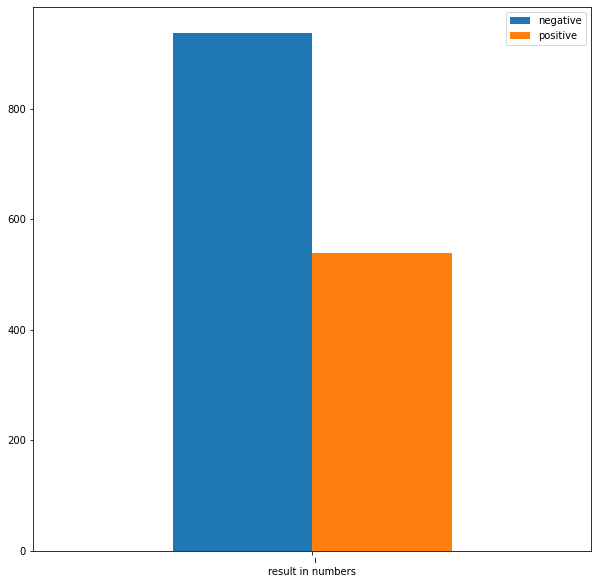

In [ ]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

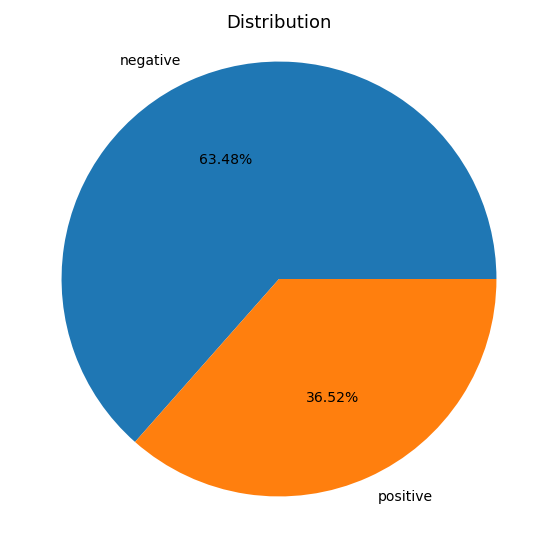

In [ ]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);